In [1]:
import numpy as np
import pandas as pd
import pickle
#from build_database import flux_obj
from scipy import interpolate
import matplotlib.pyplot as plt
import os
import itertools
import random
import os
import time
import datetime as dt

from spacepy import coordinates as coord
from spacepy.time import Ticktock

from raytracer_utils import readdump, read_rayfile, read_rayfiles
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib inline
%matplotlib nbagg
# Autoload changes made in external editor:
%load_ext autoreload
%autoreload 2
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean*1.5      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

/shared/users/asousa/software/python2/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


<IPython.core.display.Javascript object>


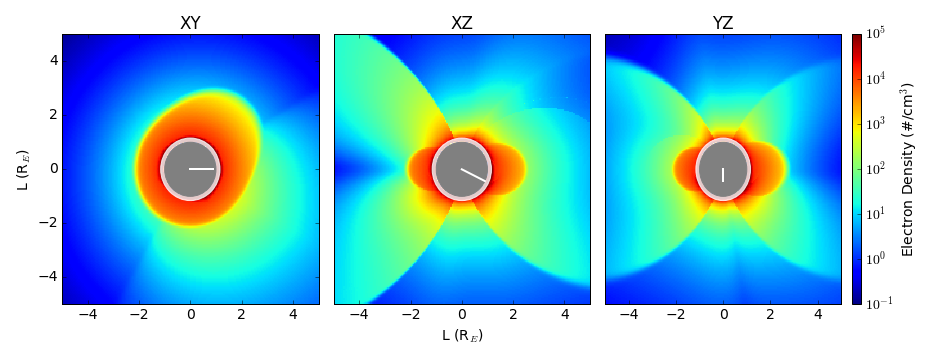

(200, 200)
(200, 200)
(200, 200)


In [280]:
from raytracer_utils import readdump
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xflib  # Fortran xform-double library (coordinate transforms)

# Coordinate transformation library
xf = xflib.xflib(lib_path='/shared/users/asousa/WIPP/3dWIPP/python/libxformd.so')


# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 12  # width in inches
fig_height = 4      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------



H_IONO=1000e3

# 2d topdown plots
# ----- Plot rays (3d version) -----

# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/lightning_power_study/rays/globe_kp8/'
rayF = 1000
lat_min = 34
lat_max = 36
lon_min = 0
lon_max = 360

figtitle_rays = 'plasmasphere_kp8.png'
# figtitle_timeseries = 'times_full_1pc_err.png'

rf = read_rayfiles(ray_root,rayF, lat_min, lat_max, lon_min, lon_max)
plasma_model_dump = os.path.join(ray_root, 'model_dump_mode2_1_XY.dat')
d_xy = readdump(plasma_model_dump)
plasma_model_dump = os.path.join(ray_root, 'model_dump_mode2_1_XZ.dat')
d_xz = readdump(plasma_model_dump)
plasma_model_dump = os.path.join(ray_root, 'model_dump_mode2_1_YZ.dat')
d_yz = readdump(plasma_model_dump)

Ne_xy = d_xy['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_xy[np.isnan(Ne_xy)] = 0
Ne_xz = d_xz['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_xz[np.isnan(Ne_xz)] = 0
Ne_yz = d_yz['Ns'][0,:,:,:].squeeze().T*1e-6
Ne_yz[np.isnan(Ne_yz)] = 0

px = np.linspace(-5,5, 200)
py = np.linspace(-5,5, 200)


flashtime = dt.datetime(2001, 1, 1, 0, 0, 0)
R_E = 6371e3 # Radius of earth in meters
D2R = (np.pi/180.0)

psize = 5
clims = [-1, 5]
# Convert to geographic coordinates for plotting:
rays = []
for r in rf:
    tmp_coords = coord.Coords(zip(r['pos'].x, r['pos'].y, r['pos'].z),'SM','car',units=['m','m','m'])
    tvec_datetime = [flashtime + dt.timedelta(seconds=s) for s in r['time']]
    tmp_coords.ticks = Ticktock(tvec_datetime) # add ticks
    tmp_coords = tmp_coords.convert('MAG','car')
    tmp_coords.sim_time = r['time']

    rays.append(tmp_coords)

#     derp = tmp_coords[0]
#     derp = derp.convert('MAG','sph')
#     print derp
    

# -------- 2D Plots -------------------
fig, ax = plt.subplots(1,3)

# ax[0].set_aspect("equal")
# ax[1].set_aspect("equal")
# ax[2].set_aspect("equal")

print np.shape(Ne_xy)
print np.shape(Ne_xz)
print np.shape(Ne_yz)

# Plot background plasma (equatorial slice)
p0 = ax[0].pcolormesh(px,py,np.log10(Ne_xy))
p0.set_clim(clims)
p1 = ax[1].pcolormesh(px,py,np.log10(Ne_xz))
p1.set_clim(clims)
p2 = ax[2].pcolormesh(px,py,np.log10(Ne_yz))
p2.set_clim(clims)



divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right",size="4%",pad=0.15)
cb = plt.colorbar(p2, cax=cax)
cb.set_label('Electron Density (#/cm$^3$)')
cticks = np.arange(clims[0],clims[1] + 1)
cb.set_ticks(cticks)
cticklabels = ['$10^{%d}$'%k for k in cticks]
cb.set_ticklabels(cticklabels)


# Plot the earth
for i in [0, 1, 2]:
    earth = plt.Circle((0,0),1,color='0.5',alpha=1, zorder=100)
    iono  = plt.Circle((0,0),(R_E + H_IONO)/R_E, color='w',alpha=0.8, zorder=99)
    ax[i].add_patch(earth)   
    ax[i].add_patch(iono)
    
# Plot rays:
for r in rays:
    ax[0].plot(r.x/R_E, r.y/R_E, linewidth=3)
    if r.y[0] < 0:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=3, zorder=101)
    else:
        ax[1].plot(r.x/R_E, r.z/R_E, linewidth=3, zorder=10)
    if r.x[0] > 0:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=3, zorder=101)
    else:
        ax[2].plot(r.y/R_E, r.z/R_E, linewidth=3, zorder=10)

# Add sun pointer:

# Get direction to sun (GSE system - x axis points to sun)
x_in = [1, 0, 0]
sun = xf.gse2sm(x_in, flashtime)

ax[0].plot([0, sun[0]], [0, sun[1]],'w', linewidth=2, zorder=101)
ax[1].plot([0, sun[0]], [0, sun[2]],'w', linewidth=2, zorder=101)
ax[2].plot([0, sun[1]], [0, sun[2]],'w', linewidth=2, zorder=101)

        

ax[0].set_title('XY')
ax[1].set_title('XZ')
ax[2].set_title('YZ')
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[1].set_xlabel('L (R$_E$)')
ax[0].set_ylabel('L (R$_E$)')

ax[0].set_xlim([-psize, psize])
ax[0].set_ylim([-psize, psize])
ax[1].set_xlim([-psize, psize])
ax[1].set_ylim([-psize, psize])
ax[2].set_xlim([-psize, psize])
ax[2].set_ylim([-psize, psize])

fig.tight_layout()

fig.savefig(figtitle_rays, ldpi=300)






# # --------------- Latex Plot Beautification --------------------------
# fig_width = 12  # width in inches
# fig_height = 6      # height in inches
# fig_size =  [fig_width+1,fig_height+1]
# params = {'figure.figsize': fig_size}
# plt.rcParams.update(params)
# # --------------- Latex Plot Beautification --------------------------





# fig2, ax2 = plt.subplots(4,1)

# for ray in rf:
#     kmag = np.linalg.norm(ray['n'], axis=1)*ray['w']/C
    
#     dkmag = 100.*np.abs((kmag[1:] - kmag[0:-1])/kmag[1:])
    
#     ax2[0].plot(ray['time'], kmag)
#     ax2[1].plot(ray['time'][1:],np.diff(kmag))
#     ax2[2].plot(ray['time'][1:], dkmag)
#     ax2[3].plot(ray['time'][1:], np.diff(ray['time']))
    
#     ax2[0].set_xlim([0, 10])
#     ax2[0].set_ylabel('Kmag')
#     ax2[1].set_xlim([0, 10])
#     ax2[1].set_ylabel('dkmag')
#     ax2[2].set_xlim([0, 10])
#     ax2[2].set_ylabel('percent change')
#     ax2[3].set_xlim([0,10])
#     ax2[3].set_ylabel('dt')

# # fig2.savefig(figtitle_timeseries, ldpi=300)


<IPython.core.display.Javascript object>


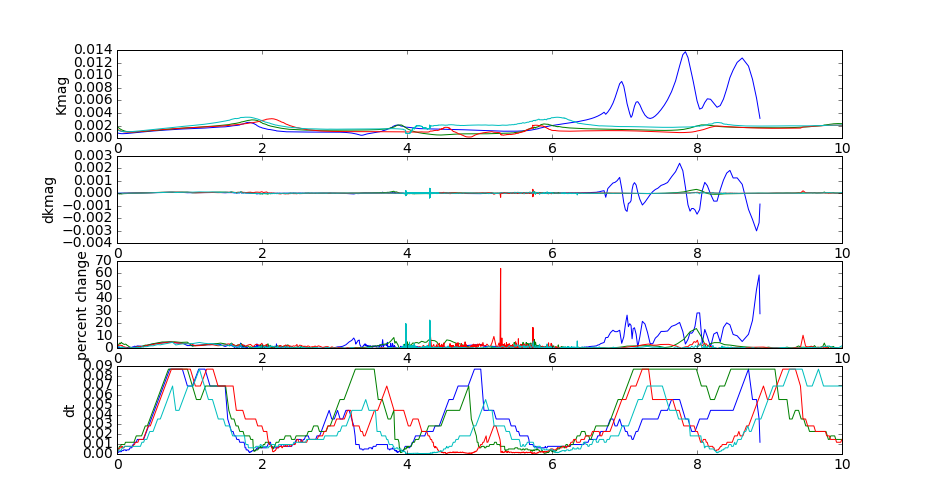

In [229]:
# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 650.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = 12  # width in inches
fig_height = 6      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 14,
          'text.fontsize': 14,
          'legend.fontsize': 14,
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------



# Plot kmag and change
# Load rayfile:
ray_root = '/shared/users/asousa/WIPP/lightning_power_study/rays/globe_fullgcpm/'
rayF = 1000
lat_min = 34
lat_max = 36
lon_min = 0
lon_max = 360

C = 2.998e8
rf = read_rayfiles(ray_root,rayF, lat_min, lat_max, lon_min, lon_max)


fig, ax = plt.subplots(4,1)

for ray in rf:
    kmag = np.linalg.norm(ray['n'], axis=1)*ray['w']/C
    
    dkmag = 100.*np.abs((kmag[1:] - kmag[0:-1])/kmag[1:])

    
    ax[0].plot(ray['time'], kmag)
    ax[1].plot(ray['time'][1:],np.diff(kmag))
    ax[2].plot(ray['time'][1:], dkmag)
    ax[3].plot(ray['time'][1:], np.diff(ray['time']))
    
    
    
    ax[0].set_xlim([0, 10])
    ax[0].set_ylabel('Kmag')
    ax[1].set_xlim([0, 10])
    ax[1].set_ylabel('dkmag')
    ax[2].set_xlim([0, 10])
    ax[2].set_ylabel('percent change')
    ax[3].set_xlim([0,10])
    ax[3].set_ylabel('dt')

(array(0.9845841392661042), array(0.9899226305551634), array(2.4959767891642146), array([ 0.,  0.,  0.,  0.,  0.,  0.]))


<IPython.core.display.Javascript object>


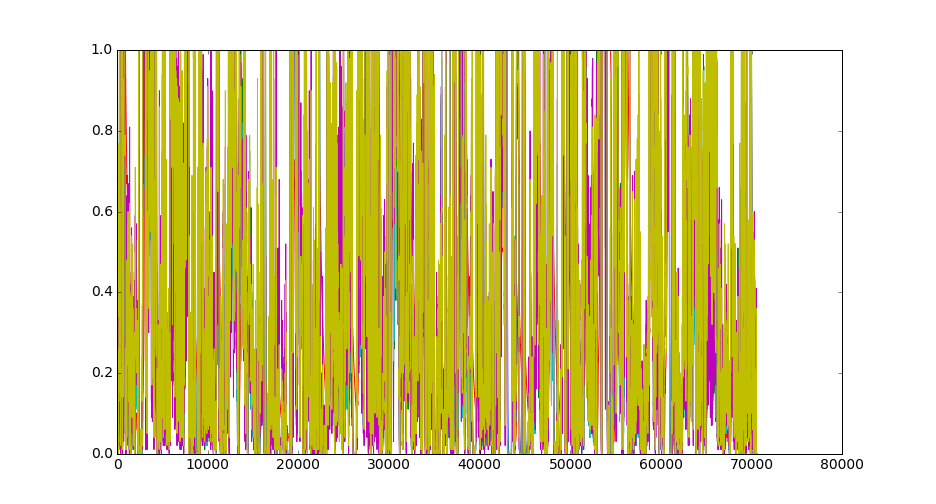

(array(0.9845841392661042), array(0.9899226305551634), array(2.4959767891642146), array([ 0.,  0.,  0.,  0.,  0.,  0.]))


In [164]:
from index_helpers import load_TS_params
import scipy.io

t = dt.datetime(2001,1,1,0,0,0)

params = load_TS_params(t)
print params


datapath = '/shared/users/asousa/software/vlf_matlabwork/indices/'
filename = os.path.join(datapath,'%04d_OMNI_5m_with_TS05_variables.mat'%t.year)
filename2= os.path.join(datapath,'%04d_OMNI_5m_with_TS05_variables.mat'%(t.year -1))
dd = scipy.io.loadmat(filename)
dd2 = scipy.io.loadmat(filename2)


dd['W']
plt.figure()
plt.plot(dd2['W'])
plt.ylim([0,1])

print params
# print dd.keys()

# dd3 = {}

# for k in dd.keys():
#     dd[k] = np.vstack([dd2[k], dd[k]])



# print dd.keys()

# plt.figure()
# plt.plot(dd['TS04_date'], 'b')
# plt.plot(dd2['TS04_date'], 'r')


In [153]:
from index_helpers import load_Kp
from index_helpers import datetime2matlabdn
from index_helpers import Kp_at
from index_helpers import Ae_at
from scipy.interpolate import interp1d

# tvec, kvec = load_Kp()

print Kp_at(dt.datetime(2001,1,1,12,0,0))
print Ae_at(dt.datetime(2001,1,1,12,0,0))

# # t = datetime2matlabdn(tvec[0])
# tt = [datetime2matlabdn(t) for t in tvec]
# print tt

0.65
1.50514997832


<IPython.core.display.Javascript object>


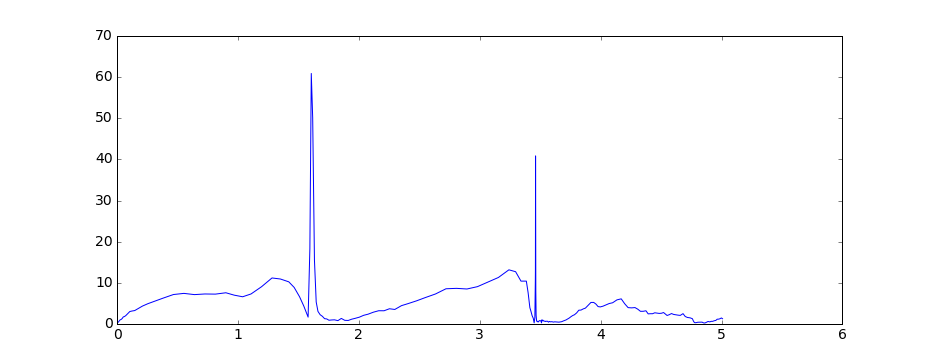

In [225]:
for ray in rf:
    dv = np.array(ray['pos'].iloc[1:,:]) - np.array(ray['pos'].iloc[0:-1,:])
    
    p1v = dv[1:,:]
    p0v = dv[0:-1,:]
    
    dangle = []
    for p1, p0 in zip(p1v, p0v):
        dangle.append(np.arccos(np.dot(p1, p0)/np.linalg.norm(p1)/np.linalg.norm(p0))*180./np.pi)

        
    ray['da'] = np.array(dangle)
#     print ray['da']



fig, ax = plt.subplots(1, 1)
# for ray in rf:
ray = rf[1]
ax.plot(ray['time'][2:], ray['da'])
    


<IPython.core.display.Javascript object>


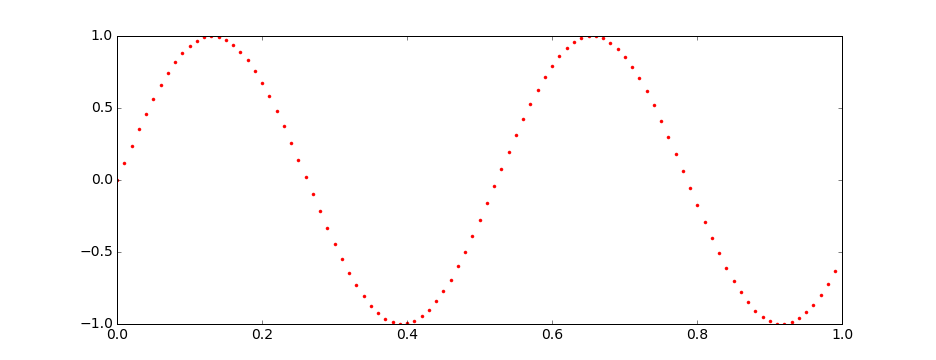

In [259]:
xx = np.arange(0,1,0.01)
yy = np.sin(xx*12.0)

fig = plt.figure()

plt.plot(xx,yy, 'r.')